In [28]:
import pandas as pd
import numpy as np
import pysindy as ps
import math
import scipy.io
from numpy import diff

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso

### Case 1: Single column with 200 trials

In [29]:
arrayNum = 1
trial = 10
t = [] 
x = []
xdot = []

#for every arrayNum
for i in range (1,arrayNum+1):
    for j in range (trial):
        mat = scipy.io.loadmat(r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-gen\single-column-dataMat\data_'+str(i)+'.mat')
        #get the data
        tp_t = mat.get("data_t")
        tp_x = mat.get("data_x")
        tp_xdot = mat.get("data_xdot")
        t.append(tp_t[:,:,j])
        x.append(tp_x[:,:,j])
        xdot.append(tp_xdot[:,:,j])
        
print(x[0].shape)
print(type(x[0]))
print(len(t))
print(t[1].shape)

(29501, 8)
<class 'numpy.ndarray'>
10
(29501, 1)


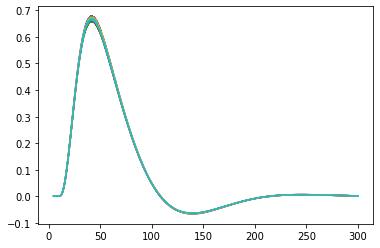

In [30]:
i = 0
for trl in x:
    cl1 = trl[:,1] - trl[:,2]
    plt.plot(t[i], cl1)
    i += 1

###  Create the training dataset

In [32]:
#training data
t_train = t
x_train = x
xdot_train = xdot


### Fit the Sindy with the training dataset

In [33]:
#I will initial with only 2 functions: one is x 
# the other is the sigmoid-liked function
library_functions = [
    lambda x : x,
    lambda x : -2.5+5/(1+np.exp(-0.56*x)) #-e0+2*e0/(1+exp(-r*x))
]
library_function_names = [
    lambda x : x,
    lambda x : 'S(' + x + ')'
]

custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

In [34]:
#pass the x and its derivative
#Threshold:
#minimum coefficient 0.0026 hi*gamma4/ti
optimizer = ps.STLSQ(threshold=0.001)
feature_library=custom_library
dt = 0.01
model = ps.SINDy(
    feature_library=feature_library,
    optimizer = optimizer
)
model.fit(x_train, t=t_train, x_dot=xdot_train,multiple_trajectories=True)
model.print()

(x0)' = 1.000 x3
(x1)' = 1.000 x4
(x2)' = 1.000 x5
(x3)' = 10.399 x0 + 0.724 x1 + -9.553 x2 + -1360.292 x3 + -110248.084 x4 + 34810.295 x5 + -1669.839 x6 + -1718409.893 x7 + -16.398 S(x0) + -0.688 S(x1) + 12.724 S(x2) + 1948.165 S(x3) + 157532.114 S(x4) + -49786.869 S(x5) + 2398.270 S(x6) + 2454850.942 S(x7)
(x4)' = -0.014 x0 + -0.017 x1 + -27.148 x4 + 858.773 x5 + -2.571 x6 + 39760.429 x7 + 0.032 S(x0) + 0.006 S(x1) + 38.544 S(x4) + -1226.966 S(x5) + 3.707 S(x6) + -56800.490 S(x7)
(x5)' = 0.007 x0 + 0.028 x1 + -0.043 x2 + 33.734 x4 + 1632.403 x5 + -18693.433 x7 + -0.010 S(x0) + -0.039 S(x1) + 0.058 S(x2) + -48.216 S(x4) + -2332.080 S(x5) + 26704.877 S(x7)
(x6)' = 1.000 x7
(x7)' = -0.010 x0 + -21.393 x4 + -121.681 x5 + -0.352 x6 + 7676.463 x7 + 0.015 S(x0) + 30.599 S(x4) + 173.784 S(x5) + 0.508 S(x6) + -10966.406 S(x7)


### Score for the time derivative prediction produced by the model

In [35]:
#multiple trajctories for this
#training data
t_test = []
x_test = []
xdot_test = []

#for every arrayNum
for i in range (2,3):
    for j in range (trial):
        mat = scipy.io.loadmat(r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-gen\single-column-dataMat\data_'+str(i)+'.mat')
        #get the data
        tp_t = mat.get("data_t")
        tp_x = mat.get("data_x")
        tp_xdot = mat.get("data_xdot")
        t_test.append(tp_t[:,:,j])
        x_test.append(tp_x[:,:,j])
        xdot_test.append(tp_xdot[:,:,j])
    
#x_test can have 200 trails
print('Model score: %f' % model.score(x_test, t = t_test, x_dot = xdot_test, multiple_trajectories=True))

Model score: 0.933496


### Plots for test data time derivative  comperation

[0. 0. 0. 0. 0. 0. 0. 0.]


C:\Users\l2016\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


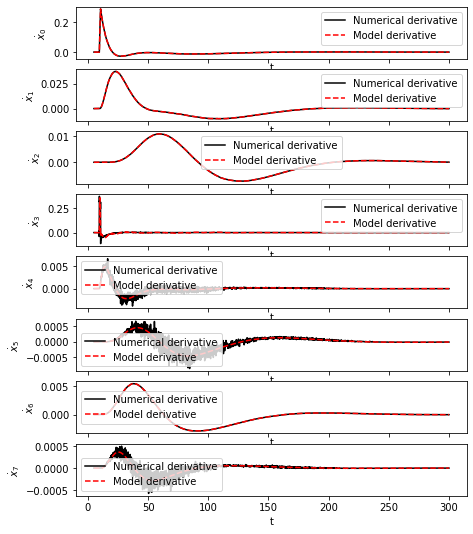

In [36]:
print(x_test[0][0,:])
#x test doing split
xdot_predicted = model.predict(x_test, multiple_trajectories=True)

fig, axs = plt.subplots(x_test[0].shape[1], 1, sharex=True, figsize=(7, 9))

for i in range(x_test[0].shape[1]):
    for j in range(1):
        axs[i].plot(t_test[j], xdot_test[j][:, i],'k')
        axs[i].plot(t_test[j], xdot_predicted[j][:, i],'r--')
        
    axs[i].legend(['Numerical derivative', 'Model derivative'])
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

### Generate model prediction X

In [79]:
# time interval of the simulation
dt = 0.1
t_sim = np.arange(10, 200, dt)

# use the x_train at 5 ms value as initial condition
    #the 1st index is 5s
x0_sim = x_test[0][500,:]
print(x0_sim)

x_test_sim = model.simulate(x0_sim, t_sim, integrator = "odeint")
print('dimension of the x_test_simulation:', x_test_sim.shape)

[3.79248307e-02 6.81319575e-06 1.53882476e-15 1.51606731e-01
 5.48590111e-05 1.20640366e-13 1.32954619e-10 1.74421030e-09]
dimension of the x_test_simulation: (1900, 8)


C:\Users\l2016\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


### Plots for model prediction performance

In [80]:
#simulation result
cl1_sim = x_test_sim[:,1] - x_test_sim[:,2]
print(len(cl1_sim))
print(len(t_sim))
#real value
cl1 = x_test[0][:,1] - x_test[0][:,2]


1900
1900


(-0.5, 1)

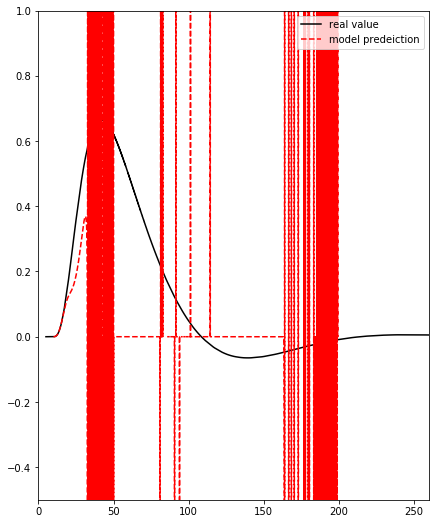

In [82]:
fig, ax = plt.subplots(figsize=(7, 9))
ax.plot(t[0], cl1,'k')
ax.plot( t_sim, cl1_sim, 'r--')
ax.legend(['real value','model predeiction'])
ax.set_xlim([0, 260])
ax.set_ylim([-0.5, 1])

### Numerical performance of the model on the test data

In [ ]:
#calculate the performance by 1 - the SE/sum of all data points 